<a href="https://colab.research.google.com/github/arampacha/reformer_fastai/blob/master/nbs/exploration/_LM_timing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Thu Jan  7 17:26:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import sys
if 'google.colab' in sys.modules:
    !pip install -Uqq fastai==2.1.10 einops datasets
    !pip install -qq git+git://github.com/arampacha/reformer_fastai.git
    !pip install -qq git+git://github.com/butchland/my_timesaver_utils.git
    !pip install -qq git+git://github.com/arampacha/pt_memprofile.git

     |████████████████████████████████| 194kB 13.9MB/s 
     |████████████████████████████████| 163kB 51.1MB/s 
     |████████████████████████████████| 61kB 12.2MB/s 
     |████████████████████████████████| 245kB 58.9MB/s 
     |████████████████████████████████| 17.7MB 190kB/s 


In [ ]:
from fastai.text.all import *

In [ ]:
from reformer_fastai.tokenizers import ByteTextTokenizer
from reformer_fastai.transformer import TransformerLM
from reformer_fastai.reformer import ReversibleLM
from reformer_fastai.metrics import bpc
from reformer_fastai.core import total_params
from my_timesaver_utils.all import MyProfileCallback
from pt_memprofile.core import MemStatsCallback

No module named 'axial_positional_embedding'


## Prepare data

In [ ]:
from datasets import load_dataset
dataset = load_dataset('tiny_shakespeare')

Using custom data configuration default


Dataset tiny_shakespeare downloaded and prepared to /root/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/da11b9a200ca715af415094b34d5c956170f184cb3a58d7789680cf81bede955. Subsequent calls will reuse this data.


In [ ]:
train_ds = dataset['train']

In [ ]:
def splitlines(sample):
    return {'line':[*sample['text'][0].split('\n')]}

In [ ]:
train_ds = train_ds.map(splitlines, batched=True, remove_columns=['text'])

In [ ]:
train_ds = train_ds.filter(lambda x: x['line'] != '')

In [ ]:
df = train_ds.data.to_pandas()
# df.head()

In [ ]:
bte = ByteTextTokenizer(is_lm=True, add_bos=True, add_eos=True)
vocab_sz = bte.vocab_size

In [ ]:
@patch
def create_item(self:LMDataLoader, seq):
    if seq>=self.n: raise IndexError
    sl = self.last_len if seq//self.bs==self.n_batches-1 else self.seq_len
    st = (seq%self.bs)*self.bl + (seq//self.bs)*self.seq_len
    txt = self.chunks[st : st+sl+1]    
    return LMTensorText(txt[:-1]),txt[1:]

In [ ]:
cut = int(len(df)*0.8)
splits = range_of(df)[:cut], range_of(df[cut:])

In [ ]:
tfms = [attrgetter("line"), bte]
dsets = Datasets(df, [tfms, tfms], splits=splits, dl_type=LMDataLoader)

In [ ]:
bs,sl = 16,128
pad_seq2seq = partial(pad_input, pad_idx=bte.pad_token_id, pad_fields=[0,1])

dls = dsets.dataloaders(bs=bs, seq_len=sl, before_batch=pad_seq2seq)

In [ ]:
dls.show_batch(max_n=2)

,text,text_
0,"<bos>To do this ruthless piece of butchery,<eos><bos>Seek you to seize and gripe into your hands<eos><bos>I wish I had a cause to seek him there,<eos><bos>B","To do this ruthless piece of butchery,<eos><bos>Seek you to seize and gripe into your hands<eos><bos>I wish I had a cause to seek him there,<eos><bos>BU"
1,"st to my soul,<eos><bos>My brother was too careless of his charge.<eos><bos>And I to Norfolk with my followers.<eos><bos>Pardon me, Margaret; pardon me,","t to my soul,<eos><bos>My brother was too careless of his charge.<eos><bos>And I to Norfolk with my followers.<eos><bos>Pardon me, Margaret; pardon me,"


## TransformerLM timing

In [ ]:
learn = Learner(dls, TransformerLM(vocab_sz, 512),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, perplexity, bpc]).to_fp16()
total_params(learn.model)

(19297027, True)

### Memory

In [ ]:
learn = learn.add_cb(MemStatsCallback())
learn.fit_one_cycle(1, 5e-4, cbs=ShortEpochCallback())

In [ ]:
learn.mem_stats.stats

,layer_idx,call_idx,layer_type,experiment,hook_type,mem_all,mem_reservd,input_shape,output_shape
0,0,0,Embedding,None,pre,115815936,134217728,"(16, 128)",None
1,0,1,Embedding,None,fwd,117913088,134217728,"(16, 128)","(128, 512)"
2,1,2,Embedding,None,pre,117914112,134217728,"(128,)",None
3,1,3,Embedding,None,fwd,118045184,134217728,"(128,)","(512,)"
4,2,4,Linear,None,pre,118962688,136314880,"(16, 128, 512)",None
...,...,...,...,...,...,...,...,...,...
979,42,979,Linear,None,fwd,173342720,538968064,"(16, 128, 2048)","(128, 512)"
980,43,980,LayerNorm,None,pre,164954112,538968064,"(16, 128, 512)",None
981,43,981,LayerNorm,None,fwd,167051264,538968064,"(16, 128, 512)","(128, 512)"
982,44,982,Linear,None,pre,158662656,538968064,"(16, 128, 512)",None


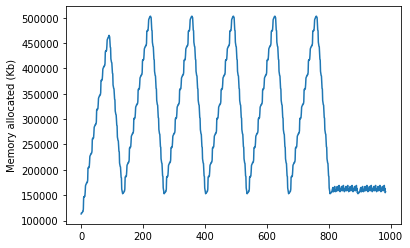

In [ ]:
learn.mem_stats.plot()

In [ ]:
learn.remove_cb(learn.cbs[-1])

### Timing

In [ ]:
learn.to_my_profile()
learn.fit_one_cycle(2, 5e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,bpc,time
0,2.181446,2.073831,0.390167,7.955238,2.991905,00:59
1,1.851900,1.776508,0.467053,5.909187,2.562960,01:00


In [ ]:
learn.my_profile.print_stats()

fit  called 1 times. max: 120.596 avg: 120.596
   epoch  called 2 times. max: 60.942 avg: 60.293
      train  called 2 times. max: 52.864 avg: 52.231
         train_batch  called 808 times. max: 0.082 avg: 0.058
            train_pred  called 808 times. max: 0.016 avg: 0.013
            train_loss  called 808 times. max: 0.003 avg: 0.001
            train_backward  called 808 times. max: 0.026 avg: 0.021
            train_step  called 808 times. max: 0.034 avg: 0.019
            train_zero_grad  called 807 times. max: 0.009 avg: 0.005
      valid  called 2 times. max: 8.074 avg: 8.054
         valid_batch  called 190 times. max: 0.017 avg: 0.015
            valid_pred  called 190 times. max: 0.015 avg: 0.013
            valid_loss  called 190 times. max: 0.002 avg: 0.001


In [ ]:
learn.my_profile.clear_stats()

In [ ]:
del learn
torch.cuda.empty_cache()

## ReversibleLM timing

In [ ]:
learn = Learner(dls, ReversibleLM(vocab_sz, 512),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, perplexity, bpc]).to_fp16()
total_params(learn.model)

(19298051, True)

### Memomry

In [ ]:
learn = learn.add_cb(MemStatsCallback())
learn.fit_one_cycle(1, 5e-4, cbs=ShortEpochCallback())

In [ ]:
learn.mem_stats.stats

,layer_idx,call_idx,layer_type,experiment,hook_type,mem_all,mem_reservd,input_shape,output_shape
0,0,0,Embedding,None,pre,115822080,465567744,"(16, 128)",None
1,0,1,Embedding,None,fwd,117919232,465567744,"(16, 128)","(128, 512)"
2,1,2,Embedding,None,pre,117920256,465567744,"(128,)",None
3,1,3,Embedding,None,fwd,118051328,465567744,"(128,)","(512,)"
4,3,4,Linear,None,pre,123163136,467664896,"(16, 128, 512)",None
...,...,...,...,...,...,...,...,...,...
2933,86,2933,LayerNorm,None,fwd,173350912,566231040,"(16, 128, 512)","(128, 512)"
2934,2,2934,LayerNorm,None,pre,160768000,566231040,"(16, 128, 512)",None
2935,2,2935,LayerNorm,None,fwd,162865152,566231040,"(16, 128, 512)","(128, 512)"
2936,87,2936,Linear,None,pre,158670848,566231040,"(16, 128, 512)",None


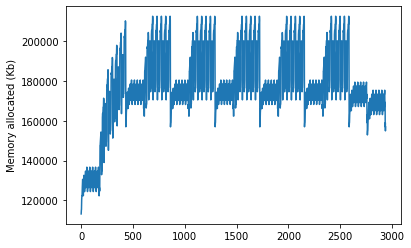

In [ ]:
learn.mem_stats.plot()

In [ ]:
learn.remove_cb(learn.cbs[-1])

### Timing

In [ ]:
learn.to_my_profile()
learn.fit_one_cycle(2, 5e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,bpc,time
0,2.212161,2.112510,0.381297,8.268970,3.047708,01:03
1,1.950185,1.895208,0.434343,6.653934,2.734208,01:03


In [ ]:
learn.my_profile.print_stats()

fit  called 1 times. max: 126.122 avg: 126.122
   epoch  called 2 times. max: 63.065 avg: 63.055
      train  called 2 times. max: 55.011 avg: 54.987
         train_batch  called 808 times. max: 0.096 avg: 0.065
            train_pred  called 808 times. max: 0.017 avg: 0.012
            train_loss  called 808 times. max: 0.002 avg: 0.001
            train_backward  called 808 times. max: 0.042 avg: 0.027
            train_step  called 808 times. max: 0.030 avg: 0.019
            train_zero_grad  called 808 times. max: 0.008 avg: 0.005
      valid  called 2 times. max: 8.096 avg: 8.062
         valid_batch  called 190 times. max: 0.018 avg: 0.015
            valid_pred  called 190 times. max: 0.015 avg: 0.014
            valid_loss  called 190 times. max: 0.002 avg: 0.001


In [ ]:
learn.my_profile.clear_stats()

In [ ]:
del learn
torch.cuda.empty_cache()

### Using Irreversible blocks

In [ ]:
learn = Learner(dls, ReversibleLM(vocab_sz, 512, rev_thres=sl+1),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, perplexity, bpc]).to_fp16()
total_params(learn.model)

(19298051, True)

### Momory

In [ ]:
learn = learn.add_cb(MemStatsCallback())
learn.fit_one_cycle(1, 5e-4, cbs=ShortEpochCallback())

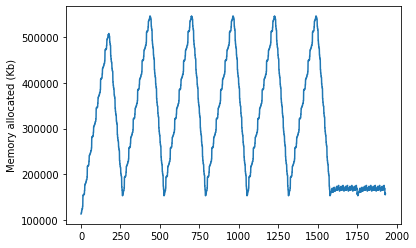

In [ ]:
learn.mem_stats.plot()

In [ ]:
learn.mem_stats.stats

,layer_idx,call_idx,layer_type,experiment,hook_type,mem_all,mem_reservd,input_shape,output_shape
0,0,0,Embedding,None,pre,115822080,796917760,"(16, 128)",None
1,0,1,Embedding,None,fwd,117919232,796917760,"(16, 128)","(128, 512)"
2,1,2,Embedding,None,pre,117920256,796917760,"(128,)",None
3,1,3,Embedding,None,fwd,118051328,796917760,"(128,)","(512,)"
4,3,4,Linear,None,pre,123163136,799014912,"(16, 128, 512)",None
...,...,...,...,...,...,...,...,...,...
1925,86,1925,LayerNorm,None,fwd,173350912,1222639616,"(16, 128, 512)","(128, 512)"
1926,2,1926,LayerNorm,None,pre,160768000,1222639616,"(16, 128, 512)",None
1927,2,1927,LayerNorm,None,fwd,162865152,1222639616,"(16, 128, 512)","(128, 512)"
1928,87,1928,Linear,None,pre,158670848,1222639616,"(16, 128, 512)",None


In [ ]:
learn.remove_cb(learn.cbs[-1])

### Timing

In [ ]:
learn.to_my_profile()
learn.fit_one_cycle(2, 5e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,bpc,time
0,1.967945,1.867223,0.440203,6.470305,2.693834,00:59
1,1.756367,1.692682,0.488143,5.434033,2.442024,00:59


In [ ]:
learn.my_profile.print_stats()

fit  called 1 times. max: 118.797 avg: 118.797
   epoch  called 2 times. max: 59.404 avg: 59.392
      train  called 2 times. max: 51.465 avg: 51.459
         train_batch  called 808 times. max: 0.071 avg: 0.058
            train_pred  called 808 times. max: 0.016 avg: 0.013
            train_loss  called 808 times. max: 0.002 avg: 0.001
            train_backward  called 808 times. max: 0.028 avg: 0.020
            train_step  called 808 times. max: 0.028 avg: 0.019
            train_zero_grad  called 808 times. max: 0.009 avg: 0.005
      valid  called 2 times. max: 7.946 avg: 7.928
         valid_batch  called 190 times. max: 0.017 avg: 0.015
            valid_pred  called 190 times. max: 0.016 avg: 0.014
            valid_loss  called 190 times. max: 0.001 avg: 0.001


In [ ]:
learn.my_profile.clear_stats()

In [ ]:
del learn
torch.cuda.empty_cache()